In [1]:
import os
from pathlib import Path
from typing import List, Tuple, Callable, Optional
import torch 
import catalyst
from catalyst import utils
from catalyst.utils.dataset import create_dataset, create_dataframe, prepare_dataset_labeling, split_dataframe
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.data.augmentor import Augmentor
from albumentations import Compose, LongestMaxSize, PadIfNeeded
from albumentations import ShiftScaleRotate, IAAPerspective, RandomBrightnessContrast, RandomGamma, \
    HueSaturationValue, ToGray, CLAHE, JpegCompression
from albumentations import Normalize
from albumentations.torch import ToTensor
import collections

import numpy as np

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [2]:
SEED = 42
from catalyst.utils.seed import set_global_seed
from catalyst.utils.torch import prepare_cudnn, get_available_gpus

set_global_seed(SEED)
prepare_cudnn(deterministic=True)

/home/olga/anaconda3/envs/linknet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/olga/anaconda3/envs/linknet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/olga/anaconda3/envs/linknet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/olga/anaconda3/envs/linknet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a fu

In [3]:
DATASET = "players"

In [4]:
from pathlib import Path

ROOT = "task/"
ALL_IMAGES = list(Path(ROOT).glob("images/*.png"))
ALL_IMAGES = list(filter(lambda x: not x.name.startswith("."), ALL_IMAGES))
print("Number of images:", len(ALL_IMAGES))

Number of images: 3750


In [5]:
from catalyst.utils.image import imread
import numpy as np

import matplotlib.pyplot as plt

def show_examples(images: List[Tuple[str, np.ndarray]]):
    _indexes = [(i, j) for i in range(2) for j in range(2)]
    
    f, ax = plt.subplots(2, 2, figsize=(16, 16))
    for (i, j), (title, img) in zip(_indexes, images):
        ax[i, j].imshow(img)
        ax[i, j].set_title(title)
    f.tight_layout()

def read_random_images(paths: List[Path]) -> List[Tuple[str, np.ndarray]]:
    data = np.random.choice(paths, size=4)
    result = []
    for d in data:
        title = f"{d.parent.name}: {d.name}"
        _image = imread(d)
        result.append((title, _image))
    
    return result

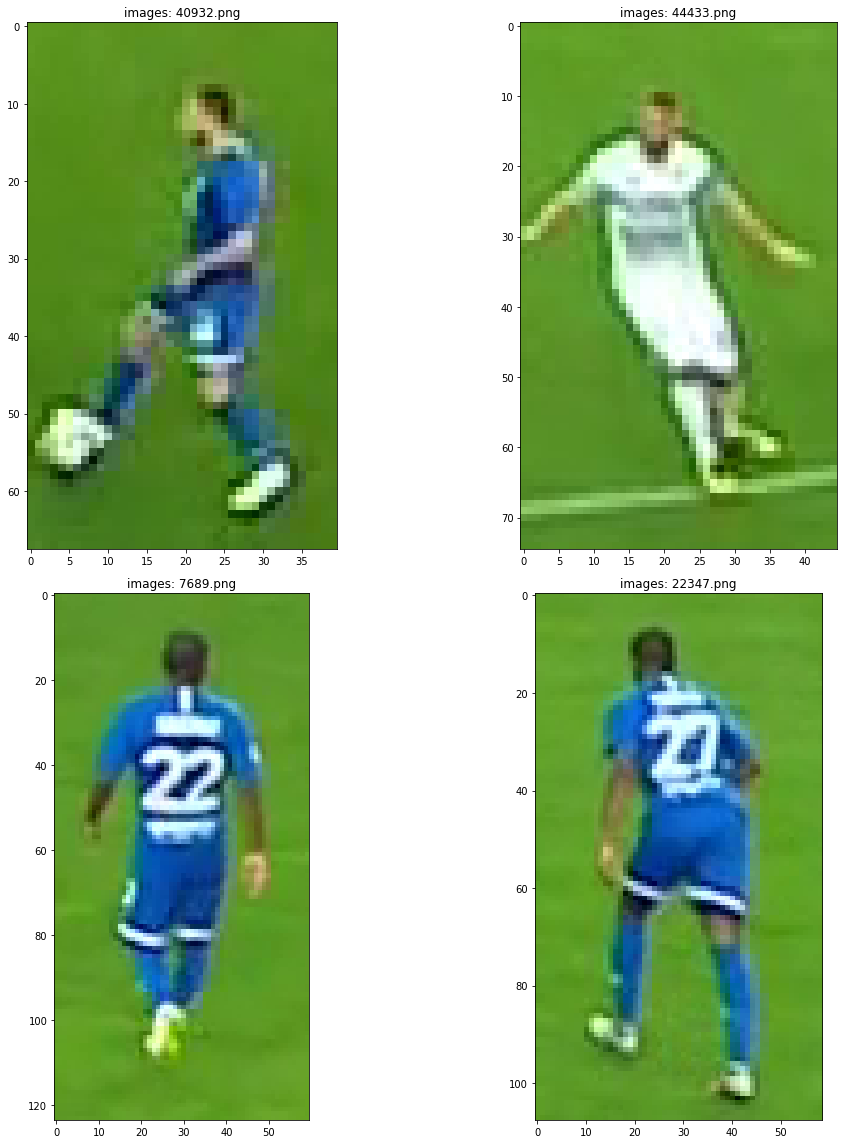

In [6]:
images = read_random_images(ALL_IMAGES)
show_examples(images)

In [7]:
from catalyst.utils.dataset import create_dataset, create_dataframe, prepare_dataset_labeling
from catalyst.utils.argparse import args_are_not_none
import pandas as pd

dataset = create_dataset(dirs=f"{ROOT}/images", extension="*.png")

In [8]:
df = pd.read_csv(f"{ROOT}/images_labelling.csv")
df.head()

,boxid,label,class_
0,40498,1,B48
1,24303,1,B48
2,48328,1,B48
3,13981,1,B48
4,19874,1,B48


In [9]:
len(df)

3750

In [10]:
print (df['label'].count())
print (df['label'].value_counts())

3750
23    150
22    150
2     150
4     150
6     150
8     150
10    150
12    150
14    150
16    150
18    150
20    150
24    150
21    150
1     150
3     150
5     150
7     150
9     150
11    150
13    150
15    150
17    150
19    150
0     150
Name: label, dtype: int64


In [11]:
print (df['class_'].count())
print (df['class_'].value_counts())

3750
A33      150
B44      150
D-       150
B5       150
A5       150
B4       150
A19      150
A31      150
C-       150
B25      150
A98      150
B27      150
A11      150
B34      150
A20      150
A55      150
A15      150
A8       150
B48      150
B22      150
B10      150
other    150
B1       150
B8       150
A57      150
Name: class_, dtype: int64


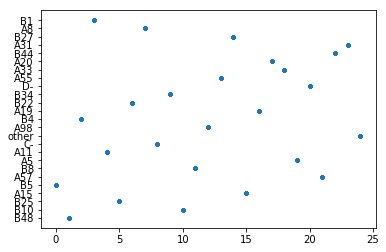

In [14]:
# creating a scatter plot of features
plt.plot(df['label'],df["class_"],marker='.',linestyle='none')
plt.show()

In [21]:
tag_to_label = prepare_dataset_labeling(df, "class_")
tag_to_label

{'A11': 0,
 'A15': 1,
 'A19': 2,
 'A20': 3,
 'A31': 4,
 'A33': 5,
 'A5': 6,
 'A55': 7,
 'A57': 8,
 'A8': 9,
 'A98': 10,
 'B1': 11,
 'B10': 12,
 'B22': 13,
 'B25': 14,
 'B27': 15,
 'B34': 16,
 'B4': 17,
 'B44': 18,
 'B48': 19,
 'B5': 20,
 'B8': 21,
 'C-': 22,
 'D-': 23,
 'other': 24}

In [22]:
from catalyst.utils.pandas import map_dataframe


df_with_labels = map_dataframe(df, tag_column="class_", class_column="label", tag2class=tag_to_label, verbose=True)
df_with_labels.head()

,boxid,label,class_
0,40498,19,B48
1,24303,19,B48
2,48328,19,B48
3,13981,19,B48
4,19874,19,B48


In [23]:
class_names = [name for name, id_ in sorted(tag_to_label.items(), key=lambda x: x[1])]
class_names

['A11',
 'A15',
 'A19',
 'A20',
 'A31',
 'A33',
 'A5',
 'A55',
 'A57',
 'A8',
 'A98',
 'B1',
 'B10',
 'B22',
 'B25',
 'B27',
 'B34',
 'B4',
 'B44',
 'B48',
 'B5',
 'B8',
 'C-',
 'D-',
 'other']

In [24]:
from catalyst.utils.dataset import split_dataframe

train_data, valid_data = split_dataframe(df_with_labels, test_size=0.15, random_state=SEED)
train_data, valid_data = train_data.to_dict('records'), valid_data.to_dict('records')

In [25]:
from catalyst.dl import utils
from catalyst.utils import get_loader
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from functools import partial

import torch

num_classes = len(tag_to_label)

# ReaderCompose collects different Readers into one pipeline
open_fn = ReaderCompose([
    
    # Reads images from the `datapath` folder using the key `input_key =" filepath "` (here should be the filename)
    # and writes it to the output dictionary by `output_key="features"` key
    ImageReader(
        input_key="filepath",
        output_key="features",
        datapath=ROOT
    ),
    
    # Reads a number from our dataframe by the key `input_key =" label "` to np.long
    # and writes it to the output dictionary by `output_key="targets"` key
    ScalarReader(
        input_key="label",
        output_key="class_",
        default_value=-1,
        dtype=np.int64
    ),
    
    # Same as above, but with one encoding
    ScalarReader(
        input_key="label",
        output_key="class__one_hot",
        default_value=-1,
        dtype=np.int64, 
        one_hot_classes=num_classes
    )
])

In [26]:
from albumentations import Compose, LongestMaxSize, PadIfNeeded
from albumentations import ShiftScaleRotate, IAAPerspective, RandomBrightnessContrast, RandomGamma, \
    HueSaturationValue, ToGray, CLAHE, JpegCompression

from albumentations import Normalize
from albumentations.torch import ToTensor

BORDER_CONSTANT = 0
BORDER_REFLECT = 2

def pre_transforms(image_size=224):
    # Convert the image to a square of size image_size x image_size
    # (keeping aspect ratio)
    result = [
        LongestMaxSize(max_size=image_size),
        PadIfNeeded(image_size, image_size, border_mode=BORDER_CONSTANT)
    ]
    
    return result

def hard_transforms():
    result = [
        # Random shifts, stretches and turns with a 50% probability
        ShiftScaleRotate( 
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=BORDER_REFLECT,
            p=0.5
        ),
        IAAPerspective(scale=(0.02, 0.05), p=0.3),
        # Random brightness / contrast with a 30% probability
        RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.3
        ),
        # Random gamma changes with a 30% probability
        RandomGamma(gamma_limit=(85, 115), p=0.3),
        # Randomly changes the hue, saturation, and color value of the input image
        HueSaturationValue(p=0.3),
        JpegCompression(quality_lower=80),
    ]
    
    return result

def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [Normalize(), ToTensor()]

def compose(_transforms):
    # combine all augmentations into one single pipeline
    result = Compose([item for sublist in _transforms for item in sublist])
    return result

In [27]:
from catalyst.data.augmentor import Augmentor
from torchvision import transforms


train_transforms = compose([pre_transforms(), hard_transforms(), post_transforms()])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([pre_transforms(), hard_transforms()])

# Takes an image from the input dictionary by the key `dict_key` and performs `train_transforms` on it.
train_data_transforms = transforms.Compose([
    Augmentor(
        dict_key="features",
        augment_fn=lambda x: train_transforms(image=x)["image"]
    )
])


# Similarly for the validation part of the dataset. 
# we only perform squaring, normalization and ToTensor
valid_data_transforms = transforms.Compose([
    Augmentor(
        dict_key="features",
        augment_fn=lambda x: valid_transforms(image=x)["image"]
    )
])

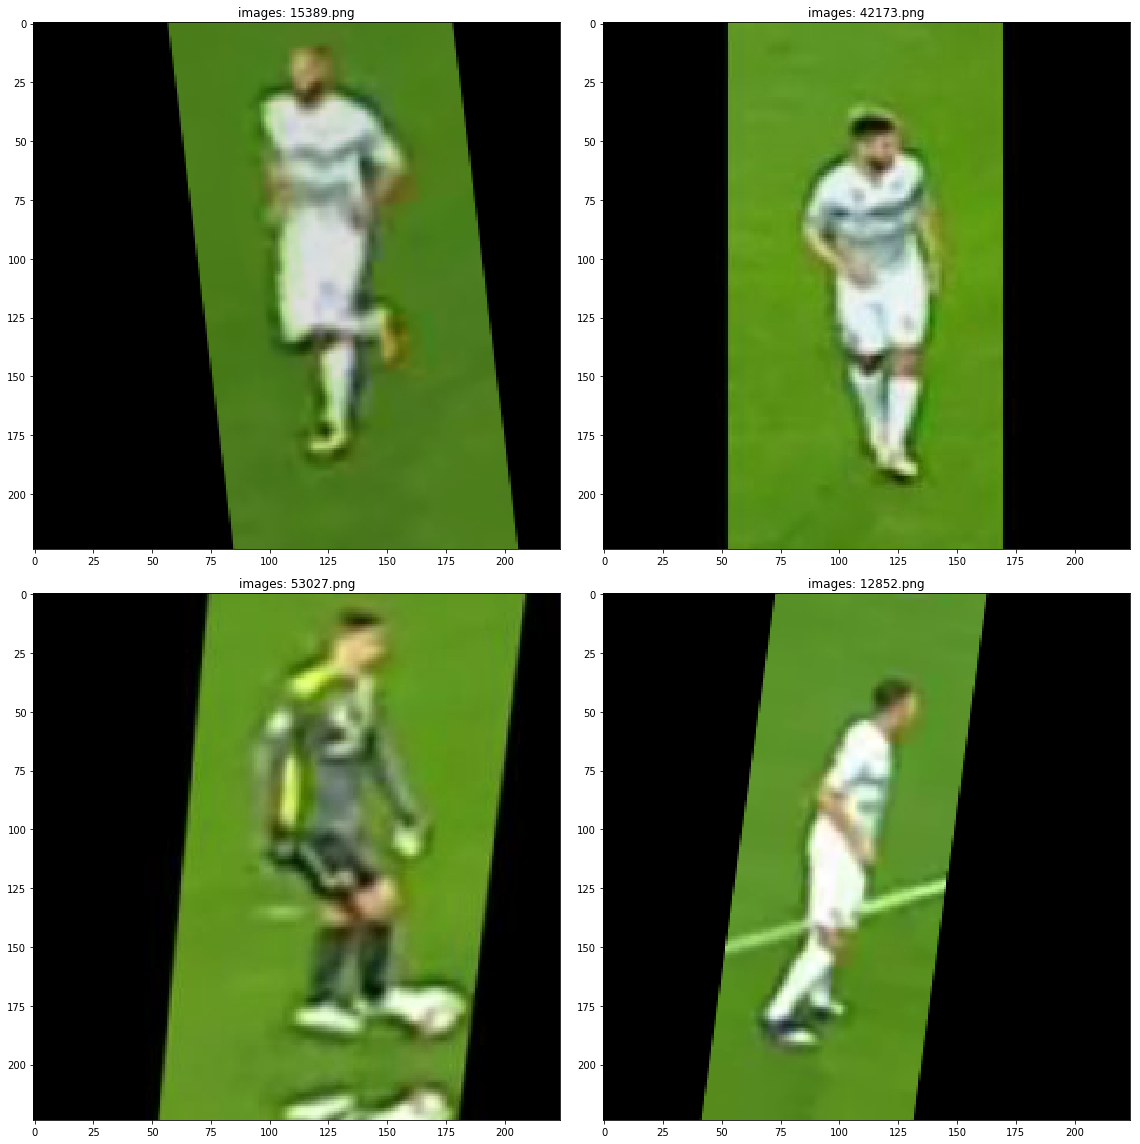

In [28]:
images = read_random_images(ALL_IMAGES)

images = [
    (title, show_transforms(image=i)["image"])
    for (title, i) in images
]
show_examples(images)